In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [94]:
# generate simple feedforward network
class FFNet(nn.Module):
    def __init__(self,layer_sizes=[],activation='relu'):
        super(FFNet,self).__init__()
        layer_sizes += [1]
        self.input_layer = nn.Linear(2,layer_sizes[0])
        self.layers = nn.ModuleList([nn.Linear(layer_sizes[i],layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])
        self.activation = activation
    
    def forward(self,x):
        if self.activation=='relu':
            actfun = F.relu
        elif self.activation=='sigmoid':
            actfun = F.sigmoid
        elif self.activation=='tanh':
            actfun = F.tanh
        elif self.activation=='squarerelu':
            actfun = lambda x: F.relu(x)**2
        elif self.activation=='sqrtrelu':
            actfun = lambda x: F.relu(x)**0.5
        else:
            raise ValueError('activation function not recognized')
        x = actfun(self.input_layer(x))
        for layer in self.layers:
            x = actfun(layer(x))
        return x

# create multiplication dataset
def generate_dataset(n_samples,min_value=0,max_value=1,train_val_test_split=(0.6,0.2)):
    # generate random dataset
    x = np.random.uniform(min_value,max_value,size=(n_samples,2))
    y = (x[:,0]*x[:,1]).reshape(-1,1)
    # split into train, validation and test
    n_train = int(n_samples*train_val_test_split[0])
    n_val = int(n_samples*train_val_test_split[1])
    x_train = x[:n_train]
    y_train = y[:n_train]
    x_val = x[n_train:n_train+n_val]
    y_val = y[n_train:n_train+n_val]
    x_test = x[n_train+n_val:]
    y_test = y[n_train+n_val:]
    return x_train,y_train,x_val,y_val,x_test,y_test

network = FFNet([10,10],activation='relu')
optimizer = torch.optim.Adam(network.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
x_train,y_train,x_val,y_val,x_test,y_test = generate_dataset(10000)

n_epochs = 10000
patience = 10
best_val_loss = np.inf
print_every = 10

# train network with early stopping
for epoch in range(n_epochs):
    # train
    network.train()
    optimizer.zero_grad()
    y_pred = network(torch.tensor(x_train,dtype=torch.float32))
    loss = F.mse_loss(y_pred,torch.tensor(y_train,dtype=torch.float32))
    loss.backward()
    optimizer.step()
    # validate
    network.eval()
    y_pred = network(torch.tensor(x_val,dtype=torch.float32))
    val_loss = F.mse_loss(y_pred,torch.tensor(y_val,dtype=torch.float32)).item()
    if print_every>0 and epoch%print_every==0:
        print('Epoch {}: train loss {:.4f}, val loss {:.4f}'.format(epoch,loss.item(),val_loss))
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 10
    else:
        patience -= 1
    if patience == 0:
        break
    scheduler.step(val_loss)


Epoch 0: train loss 0.0692, val loss 0.0659
Epoch 10: train loss 0.0539, val loss 0.0510
Epoch 20: train loss 0.0461, val loss 0.0435
Epoch 30: train loss 0.0428, val loss 0.0403
Epoch 40: train loss 0.0404, val loss 0.0379
Epoch 50: train loss 0.0376, val loss 0.0352
Epoch 60: train loss 0.0345, val loss 0.0323
Epoch 70: train loss 0.0313, val loss 0.0291
Epoch 80: train loss 0.0278, val loss 0.0257
Epoch 90: train loss 0.0242, val loss 0.0222
Epoch 100: train loss 0.0206, val loss 0.0188
Epoch 110: train loss 0.0173, val loss 0.0156
Epoch 120: train loss 0.0143, val loss 0.0128
Epoch 130: train loss 0.0117, val loss 0.0103
Epoch 140: train loss 0.0095, val loss 0.0083
Epoch 150: train loss 0.0078, val loss 0.0068
Epoch 160: train loss 0.0065, val loss 0.0056
Epoch 170: train loss 0.0056, val loss 0.0048
Epoch 180: train loss 0.0049, val loss 0.0043
Epoch 190: train loss 0.0045, val loss 0.0039
Epoch 200: train loss 0.0041, val loss 0.0036
Epoch 210: train loss 0.0039, val loss 0.0034

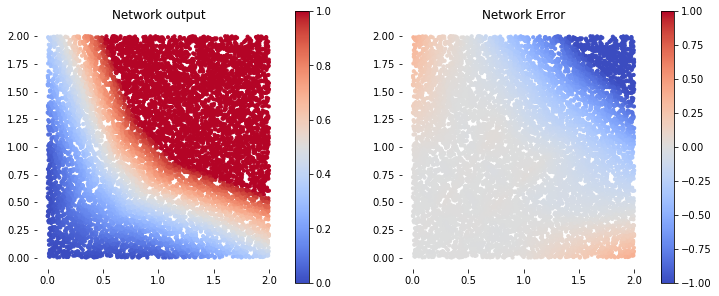

In [95]:
# plot neural network in a 2D space
def plot_network(network,n_samples=10000,min_value=0,max_value=2):
    # generate random dataset
    x = np.random.uniform(min_value,max_value,size=(n_samples,2))
    y = (x[:,0]*x[:,1]).reshape(-1,1)
    # plot
    network.eval()
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(x[:,0],x[:,1],c=network(torch.tensor(x,dtype=torch.float32)).detach().numpy(),s=10,cmap='coolwarm',vmin=0,vmax=1)
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.box(False)
    plt.title('Network output')
    plt.subplot(1,2,2)
    # plt.scatter(x[:,0],x[:,1],c=y.reshape(-1),s=10,cmap='coolwarm',vmin=0,vmax=1)
    #scatterplot of the difference between the predicted and the true values
    plt.scatter(x[:,0],x[:,1],c=network(torch.tensor(x,dtype=torch.float32)).detach().numpy().T[0]-y.reshape(-1),s=10,cmap='coolwarm',vmin=-1,vmax=1)
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.box(False)
    plt.title('Network Error')
    plt.show()

plot_network(network,)

In [2]:
genome_size = 30

In [3]:
def ih_weight_inheritance(parent_matrix,parent_genome,child_genome,synaptic_unreliability):
    with torch.no_grad():
        mean_weights = parent_matrix.mean()
        std_weights = parent_matrix.std()
        temp = mean_weights + std_weights * torch.randn((parent_genome.shape[0],parent_matrix.shape[1]))
        temp[parent_genome==1,:] = (parent_matrix-mean_weights)/std_weights
        child_matrix = temp[child_genome==1,:]
        mutated_child_matrix = child_matrix * (1 + synaptic_unreliability*torch.randn(child_matrix.shape))
        return mutated_child_matrix

def ih_bias_inheritance(parent_matrix,parent_genome,child_genome,synaptic_unreliability):
    with torch.no_grad():
        mean_weights = parent_matrix.mean()
        std_weights = parent_matrix.std()
        temp = mean_weights + std_weights * torch.randn(parent_genome.shape[0])
        temp[parent_genome==1] = parent_matrix
        child_matrix = temp[child_genome==1]
        mutated_child_matrix = child_matrix * (1 + synaptic_unreliability*torch.randn(child_matrix.shape))
        return mutated_child_matrix

def hh_weight_inheritance(parent_matrix,parent_genome,child_genome,synaptic_unreliability):
    with torch.no_grad():
        mean_weights = parent_matrix.mean()
        std_weights = parent_matrix.std()
        temp = mean_weights + std_weights * torch.randn((parent_genome.shape[0],parent_genome.shape[0]))
        temp[parent_genome==1,:][:,parent_genome==1] = parent_matrix
        child_matrix = temp[child_genome==1,:][:,child_genome==1]
        mutated_child_matrix = child_matrix * (1 + synaptic_unreliability*torch.randn(child_matrix.shape))
        return mutated_child_matrix

def hh_bias_inheritance(parent_matrix,parent_genome,child_genome,synaptic_unreliability):
    with torch.no_grad():
        mean_weights = parent_matrix.mean()
        std_weights = parent_matrix.std()
        temp = mean_weights + std_weights * torch.randn(parent_genome.shape[0])
        temp[parent_genome==1] = parent_matrix
        child_matrix = temp[child_genome==1]
        mutated_child_matrix = child_matrix * (1 + synaptic_unreliability*torch.randn(child_matrix.shape))
        return mutated_child_matrix

def ho_weight_inheritance(parent_matrix,parent_genome,child_genome,synaptic_unreliability):
    with torch.no_grad():
        mean_weights = parent_matrix.mean()
        std_weights = parent_matrix.std()
        temp = mean_weights + std_weights * torch.randn((parent_matrix.shape[0],parent_genome.shape[0]))
        temp[:,parent_genome==1] = parent_matrix
        child_matrix = temp[:,child_genome==1]
        mutated_child_matrix = child_matrix * (1 + synaptic_unreliability*torch.randn(child_matrix.shape))
        return mutated_child_matrix

def ho_bias_inheritance(parent_matrix,synaptic_unreliability):
    with torch.no_grad():
        child_matrix = parent_matrix
        mutated_child_matrix = child_matrix * (1 + synaptic_unreliability*torch.randn(child_matrix.shape))
        return mutated_child_matrix
        
class SimpleRecurrentBrain(nn.Module):
    def __init__(self, n_inputs, reservoir_genome, n_outputs,w_ih=None,w_hh=None,w_ho=None,b_ih=None,b_hh=None,b_ho=None):
        super().__init__()
        self.n_inputs = n_inputs
        self.reservoir_genome = reservoir_genome
        self.genome_size = reservoir_genome.shape[0]
        self.n_outputs = n_outputs
        self.n_reservoir = torch.sum(reservoir_genome)
        self.reservoir = nn.RNN(self.n_inputs, self.n_reservoir)
        self.readout = nn.Linear(self.n_reservoir, self.n_outputs)
        if w_ih is not None:
            self.reservoir.weight_ih_l0.data = w_ih
        if w_hh is not None:
            self.reservoir.weight_hh_l0.data = w_hh
        if w_ho is not None:
            self.readout.weight.data = w_ho
        if b_ih is not None:
            self.reservoir.bias_ih_l0.data = b_ih
        if b_hh is not None:
            self.reservoir.bias_hh_l0.data = b_hh
        if b_ho is not None:
            self.readout.bias.data = b_ho
    
    def forward(self, x, h):
        x,h = self.reservoir(x,h)
        x = self.readout(x)
        return x,h
    
    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.n_reservoir)

In [4]:
def fitness(RNN,specialist_loss,generalist_loss,alpha,beta,gamma,max_reservoir):
    """
    RNN: a SimpleRecurrentBrain object
    specialist_loss: loss on trained task
    generalist_loss: loss on untrained task
    alpha: weight for network size
    beta: weight for synaptic density
    gamma: weight for generalist loss
    """
    with torch.no_grad():
        fitness = alpha*max_reservoir/RNN.n_reservoir + beta*(RNN.n_reservoir**2/torch.sum(torch.abs(RNN.reservoir.weight_hh_l0))) + gamma/generalist_loss + 1/specialist_loss
    return fitness

In [5]:
temp = SimpleRecurrentBrain(n_inputs=4, reservoir_genome=torch.tensor(np.random.choice(2,size=genome_size)), n_outputs=4)

In [6]:
fitness(temp,specialist_loss=1,generalist_loss=1,alpha=1,beta=1,gamma=1,max_reservoir=genome_size)

tensor(11.5616)

In [7]:
def mutateBrain(parent,neuron_birth_rate,neuron_death_rate,synaptic_unreliability):
    """
    Takes a parent RNN and creates a child RNN by mutating it.
    
    Parameters:
    parent: A SimpleRecurrentBrain object
    neuron_birth_rate: rate of birth of new neurons
    neuron_death_rate: rate of death of existing neurons
    synaptic_reliability: noise in the transmission of synaptic weights
    
    Returns:
    child: A SimpleRecurrentBrain object
    """
    parent_genome = parent.reservoir_genome
    n_existing_neurons = torch.sum(parent_genome)

    child_genome = parent_genome.clone()
    
    n_new_neurons = np.min([np.random.poisson(neuron_birth_rate),parent.genome_size-n_existing_neurons])
    new_neurons = np.zeros(parent.genome_size-n_existing_neurons)
    new_neurons[np.random.choice(parent.genome_size-n_existing_neurons,size=n_new_neurons,replace=False)] = 1
    child_genome[child_genome==0] = torch.tensor(new_neurons,dtype=torch.int)

    n_existing_neurons = torch.sum(child_genome)
    n_dead_neurons = np.min([np.random.poisson(neuron_death_rate),n_existing_neurons-1])
    dead_neurons = np.ones(n_existing_neurons)
    dead_neurons[np.random.choice(n_existing_neurons,size=n_dead_neurons,replace=False)] = 0
    child_genome[child_genome==1] = torch.tensor(dead_neurons,dtype=torch.int)

    w_ih = ih_weight_inheritance(parent.reservoir.weight_ih_l0.data,parent_genome,child_genome,synaptic_unreliability)
    w_hh = hh_weight_inheritance(parent.reservoir.weight_hh_l0.data,parent_genome,child_genome,synaptic_unreliability)
    w_ho = ho_weight_inheritance(parent.readout.weight.data,parent_genome,child_genome,synaptic_unreliability)
    b_ih = ih_bias_inheritance(parent.reservoir.bias_ih_l0.data,parent_genome,child_genome,synaptic_unreliability)
    b_hh = hh_bias_inheritance(parent.reservoir.bias_hh_l0.data,parent_genome,child_genome,synaptic_unreliability)
    b_ho = ho_bias_inheritance(parent.readout.bias.data,synaptic_unreliability)

    child = SimpleRecurrentBrain(n_inputs=parent.n_inputs, reservoir_genome=child_genome, n_outputs=parent.n_outputs,w_ih=w_ih,w_hh=w_hh,w_ho=w_ho,b_ih=b_ih,b_hh=b_hh,b_ho=b_ho)
    return child
    

In [8]:
def survival(population):
    fitnesses = np.array([fitness(RNN,specialist_loss=1,generalist_loss=1,alpha=1,beta=1,gamma=1,max_reservoir=genome_size) for RNN in population])
    relative_fitnesses = fitnesses/np.sum(fitnesses)
    # print(relative_fitnesses)
    population = [mutateBrain(population[i],neuron_birth_rate=0.1,neuron_death_rate=0.1,synaptic_unreliability=0.1) for i in np.random.choice(len(population),size=len(population),p=relative_fitnesses)]
    return population

In [9]:
brain_sizes = []
brain_weights = []
with torch.no_grad():
    population = [SimpleRecurrentBrain(n_inputs=4, reservoir_genome=torch.tensor(np.random.choice(2,size=genome_size)), n_outputs=4) for i in range(100)]
    for i in tqdm(range(30)):
        population = survival(population)
        brain_sizes.append([RNN.n_reservoir for RNN in population])
        brain_weights.append([torch.sum(torch.abs(RNN.reservoir.weight_hh_l0))/RNN.n_reservoir**2 for RNN in population])

100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


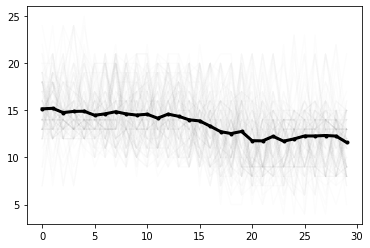

In [10]:
plt.plot(np.mean(brain_sizes,axis=1),color='k',linewidth=3,marker='o',markersize=3)
#plt.fill_between(range(len(brain_sizes)),np.mean(brain_sizes,axis=1)-np.std(brain_sizes,axis=1),np.mean(brain_sizes,axis=1)+np.std(brain_sizes,axis=1),alpha=0.3)
plt.plot(brain_sizes,color='k',alpha=0.01)
plt.show()

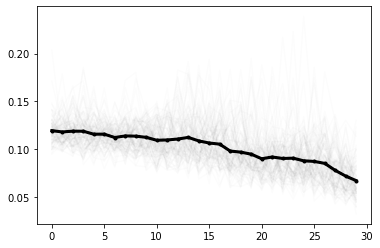

In [11]:
plt.plot(np.mean(brain_weights,axis=1),color='k',linewidth=3,marker='o',markersize=3)
plt.plot(brain_weights,color='k',alpha=0.01)
plt.show()

In [13]:
from FlYMazeRL.agents.classical import IQLearner_esoftmax
from FlYMazeRL.gym.environment import ymaze_static
from FlYMazeRL.utils import generate_random_schedule_with_blocks
from FlYMazeRL.utils import draw_schedule
# # Specialist Task is to learn association with certain rewards
# # Generalist Task is to learn association with probabilistic rewards

# n_specialist_datasets = 500
# n_generalist_datasets = 500

# testLearnerModel = IQLearner_esoftmax(env)
# testLearnerModel.load('modelfits/IQES_2022_02_25_12_22_05.nc',sample_from_population=False)

# specialist_dataset_schedule = []
# specialist_dataset_behaviour = []
# for i in tqdm(range(n_specialist_datasets)):
#     arm = 1
#     schedule = generate_random_schedule_with_blocks(100,[1-float(arm)],[float(arm)])
#     env = ymaze_static(100,schedule=schedule)
#     specialist_dataset_schedule.append(schedule)

#     testLearnerModel.next_episode()
#     specialist_dataset_behaviour.append(np.array([testLearnerModel.action_history,testLearnerModel.reward_history]))
#     testLearnerModel.reset_agent()

# generalist_dataset_schedule = []
# generalist_dataset_behaviour = []
# for i in tqdm(range(n_generalist_datasets)):
#     arm = np.random.uniform()
#     schedule = generate_random_schedule_with_blocks(100,[float(arm)],[1-float(arm)])
#     env = ymaze_static(100,schedule=schedule)
#     generalist_dataset_schedule.append(schedule)

#     testLearnerModel.next_episode()
#     generalist_dataset_behaviour.append(np.array([testLearnerModel.action_history,testLearnerModel.reward_history]))
#     testLearnerModel.reset_agent()



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



In [14]:
draw_schedule(specialist_dataset_schedule[0],np.array(specialist_dataset_behaviour)[:,0])

NameError: name 'specialist_dataset_schedule' is not defined

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


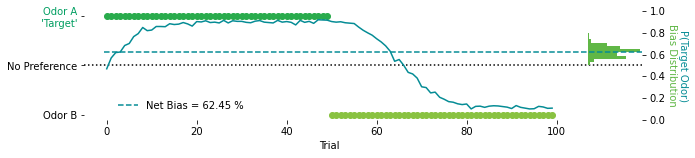

In [17]:
schedule = generate_random_schedule_with_blocks(100,[1.,0.],[0.,1.])
env = ymaze_static(100,schedule=schedule)
testLearnerModel = IQLearner_esoftmax(env)
from FlYMazeRL.utils import get_schedule_histories,generate_params_from_fits

params, policy_params = generate_params_from_fits(IQLearner_esoftmax,500)
action_histories = get_schedule_histories(env,IQLearner_esoftmax,500,params={},policy_params={})
draw_schedule(schedule,action_histories)